In [1]:
import pandas as pd

# Load the dataset
data = pd.read_csv('adult_with_headers.csv')  # Ensure the file is in the correct directory

# Display basic information
print(data.info())
print(data.describe())
print(data.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education_num   32561 non-null  int64 
 5   marital_status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital_gain    32561 non-null  int64 
 11  capital_loss    32561 non-null  int64 
 12  hours_per_week  32561 non-null  int64 
 13  native_country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB
None
                age        fnlwgt  education_num  capital_gain  capital_loss  \
count  3

In [7]:
# Correct way to handle missing values
data['workclass'] = data['workclass'].fillna(data['workclass'].mode()[0])
data['occupation'] = data['occupation'].fillna(data['occupation'].mode()[0])
data['native_country'] = data['native_country'].fillna(data['native_country'].mode()[0])


In [8]:
# Check for missing values after imputation
print(data.isnull().sum())


age               0
workclass         0
fnlwgt            0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
income            0
dtype: int64


In [9]:
# Apply One-Hot Encoding
categorical_one_hot = ['marital_status', 'relationship']
data_one_hot = pd.get_dummies(data, columns=categorical_one_hot, drop_first=True)

# Check the updated dataset
print(data_one_hot.head())


   age          workclass  fnlwgt   education  education_num  \
0   39          State-gov   77516   Bachelors             13   
1   50   Self-emp-not-inc   83311   Bachelors             13   
2   38            Private  215646     HS-grad              9   
3   53            Private  234721        11th              7   
4   28            Private  338409   Bachelors             13   

           occupation    race      sex  capital_gain  capital_loss  ...  \
0        Adm-clerical   White     Male          2174             0  ...   
1     Exec-managerial   White     Male             0             0  ...   
2   Handlers-cleaners   White     Male             0             0  ...   
3   Handlers-cleaners   Black     Male             0             0  ...   
4      Prof-specialty   Black   Female             0             0  ...   

   marital_status_ Married-civ-spouse marital_status_ Married-spouse-absent  \
0                               False                                 False   
1     

In [11]:
# Check column names
print(data_one_hot.columns.tolist())


['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'occupation', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'income', 'marital_status_ Married-AF-spouse', 'marital_status_ Married-civ-spouse', 'marital_status_ Married-spouse-absent', 'marital_status_ Never-married', 'marital_status_ Separated', 'marital_status_ Widowed', 'relationship_ Not-in-family', 'relationship_ Other-relative', 'relationship_ Own-child', 'relationship_ Unmarried', 'relationship_ Wife', 'age_squared']


In [12]:
# Feature 2: Interaction between hours_per_week and education_num
data_one_hot['hours_education_interaction'] = data_one_hot['hours_per_week'] * data_one_hot['education_num']

# Check the new features
print(data_one_hot[['age', 'age_squared', 'hours_per_week', 'education_num', 'hours_education_interaction']].head())


   age  age_squared  hours_per_week  education_num  \
0   39         1521              40             13   
1   50         2500              13             13   
2   38         1444              40              9   
3   53         2809              40              7   
4   28          784              40             13   

   hours_education_interaction  
0                          520  
1                          169  
2                          360  
3                          280  
4                          520  


In [14]:
# List of numerical features
numerical_features = ['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']

# Add the newly created features
numerical_features += ['age_squared', 'hours_education_interaction']


In [15]:
from sklearn.ensemble import IsolationForest

# Apply Isolation Forest to detect outliers
iso_forest = IsolationForest(contamination=0.05, random_state=42)  # 5% expected outliers
outliers = iso_forest.fit_predict(data_one_hot[numerical_features])

# Mark outliers as True (1) and inliers as False (-1)
data_one_hot['outlier'] = outliers == -1

# Filter out outliers
data_no_outliers = data_one_hot[data_one_hot['outlier'] == False]

# Check the shape before and after removing outliers
print(f"Original Data Shape: {data_one_hot.shape}")
print(f"Data Shape After Removing Outliers: {data_no_outliers.shape}")


Original Data Shape: (32561, 27)
Data Shape After Removing Outliers: (30933, 27)


In [ ]:
!python -m pip install --upgrade pip setuptools wheel
!python -m pip install ppscore --use-pep517


In [ ]:
import ppscore as pps

# Apply PPS analysis to the data without outliers
pps_matrix = pps.score_models(data_no_outliers, 'income')

# Display the PPS score matrix
pps_sorted = pps_matrix.sort_values(by='predictability', ascending=False)
print(pps_sorted[['x', 'y', 'predictability']].head(10))  # Top 10 features


In [ ]:
#Building a Predictive Model
from sklearn.model_selection import train_test_split

# Define features and target
X = data_no_outliers.drop(['income', 'outlier'], axis=1)  # Dropping 'income' and 'outlier' columns
y = data_no_outliers['income'].apply(lambda x: 1 if x == '>50K' else 0)  # Binary target

# Split the dataset into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
from sklearn.linear_model import LogisticRegression

# Initialize and train the model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)


In [ ]:
#Evaluate the Model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Make predictions
y_pred = log_reg.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, log_reg.predict_proba(X_test)[:, 1])

# Calculate AUC score
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Display AUC Score
print("AUC Score:", roc_auc)


In [20]:
from sklearn.model_selection import train_test_split

# Define features and target
X = data_no_outliers.drop(['income', 'outlier'], axis=1)
y = data_no_outliers['income'].apply(lambda x: 1 if x == '>50K' else 0)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [22]:
# Summary statistics
print("Summary Statistics:\n", data_no_outliers.describe())

# Data types and missing values
print("\nData Types:\n", data_no_outliers.dtypes)
print("\nMissing Values:\n", data_no_outliers.isnull().sum())


Summary Statistics:
                 age        fnlwgt  education_num  capital_gain  capital_loss  \
count  30933.000000  3.093300e+04   30933.000000  30933.000000  30933.000000   
mean      37.839039  1.881471e+05      10.068923    485.314777     57.022015   
std       12.905775  1.018475e+05       2.429951   2145.679029    318.787064   
min       17.000000  1.228500e+04       1.000000      0.000000      0.000000   
25%       27.000000  1.181490e+05       9.000000      0.000000      0.000000   
50%       36.000000  1.781340e+05      10.000000      0.000000      0.000000   
75%       47.000000  2.351670e+05      12.000000      0.000000      0.000000   
max       90.000000  1.484705e+06      16.000000  34095.000000   3900.000000   

       hours_per_week   age_squared  hours_education_interaction  
count    30933.000000  30933.000000                 30933.000000  
mean        40.314906   1598.346523                   409.300068  
std         11.346556   1070.001325                   161

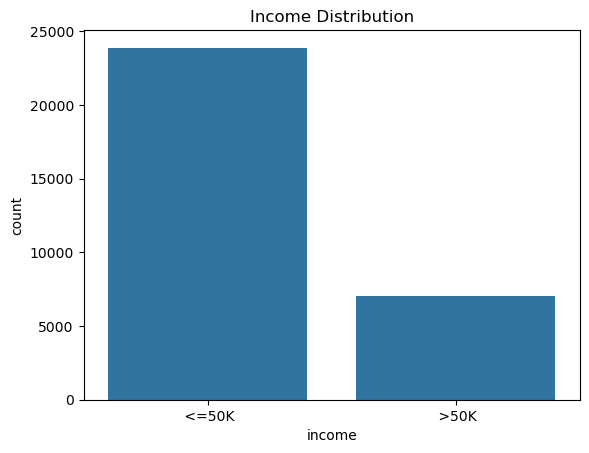

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot income distribution
sns.countplot(x='income', data=data_no_outliers)
plt.title('Income Distribution')
plt.show()


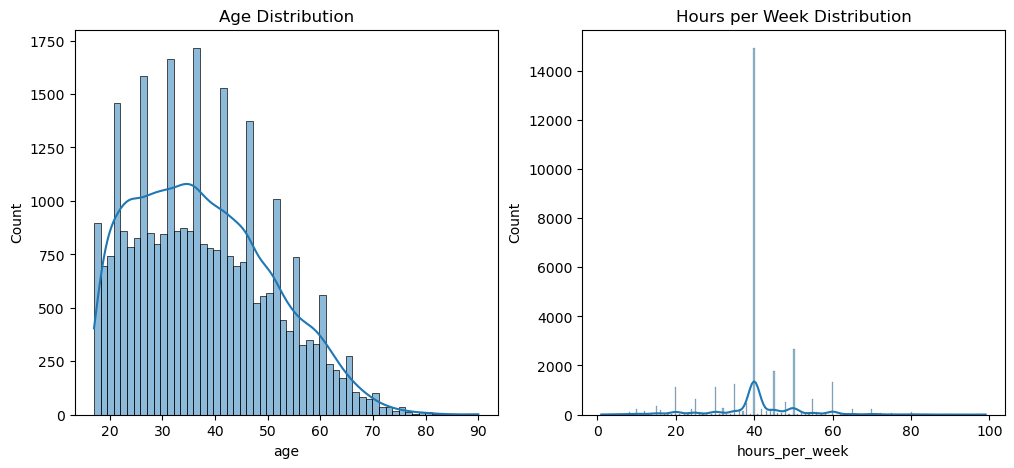

In [24]:
# Histogram for age and hours per week
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(data_no_outliers['age'], kde=True, ax=axs[0]).set(title='Age Distribution')
sns.histplot(data_no_outliers['hours_per_week'], kde=True, ax=axs[1]).set(title='Hours per Week Distribution')
plt.show()


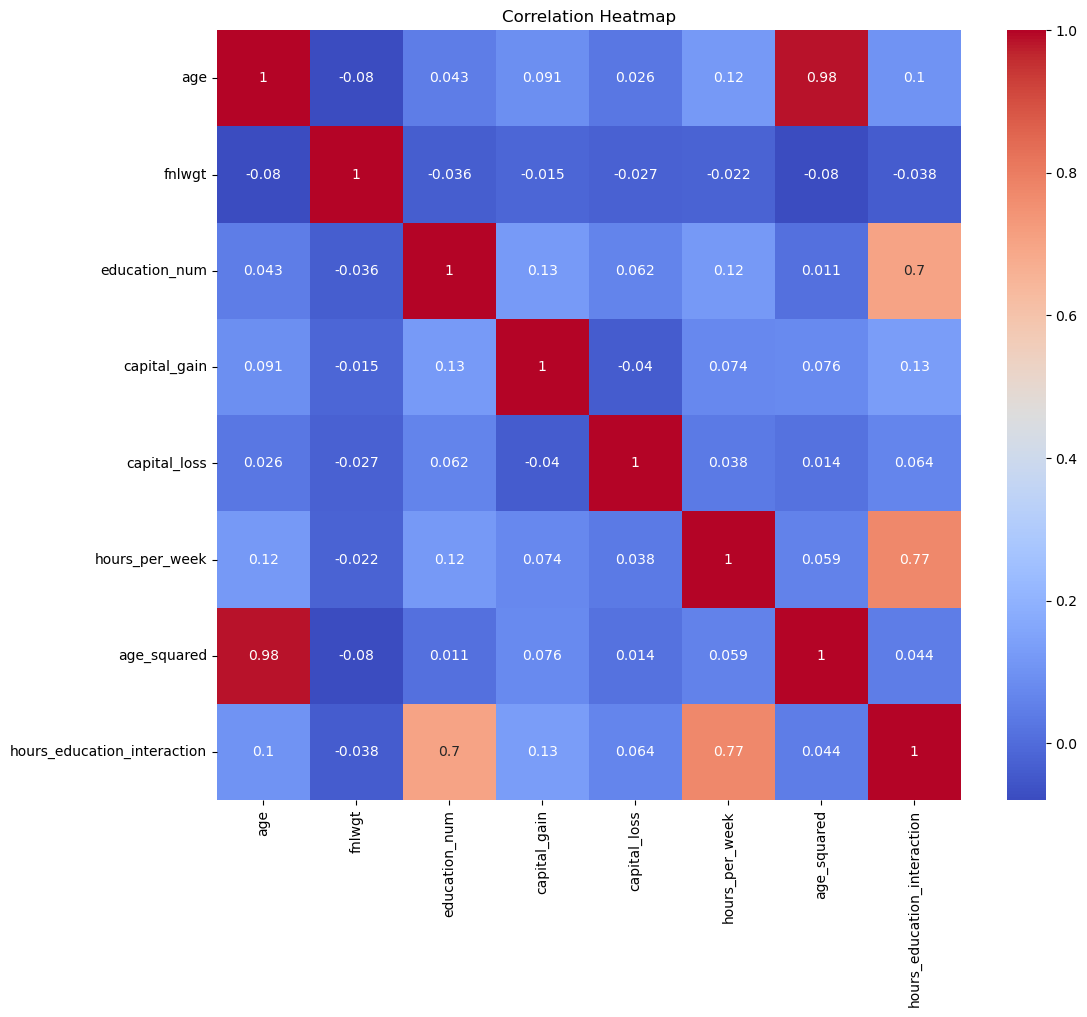

In [26]:
# Selecting only numerical columns
numerical_features = data_no_outliers.select_dtypes(include=['int64', 'float64']).columns

# Correlation heatmap for numerical features only
plt.figure(figsize=(12, 10))
sns.heatmap(data_no_outliers[numerical_features].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


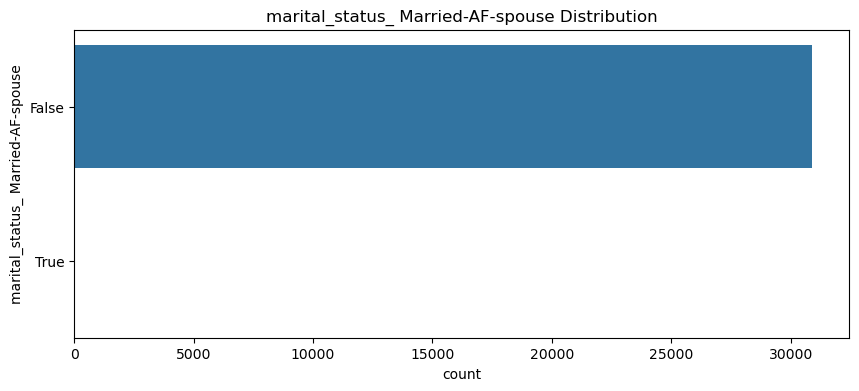

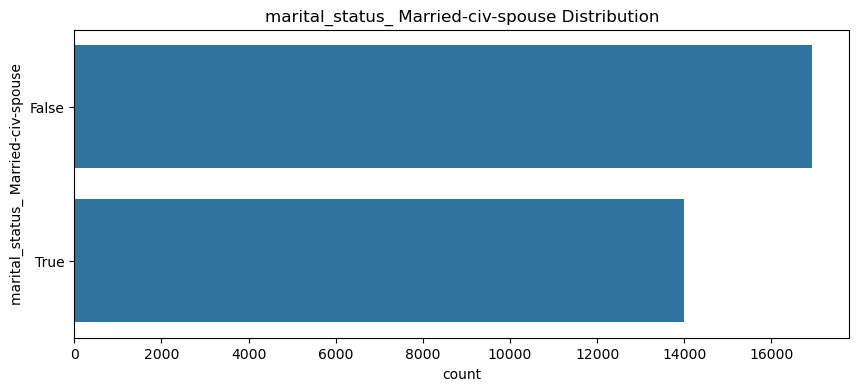

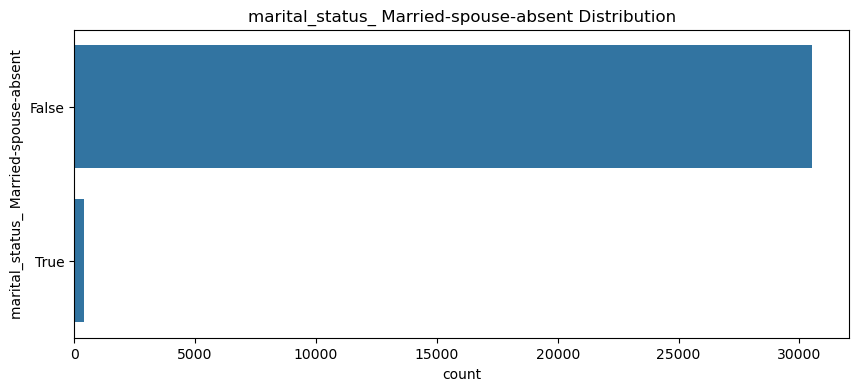

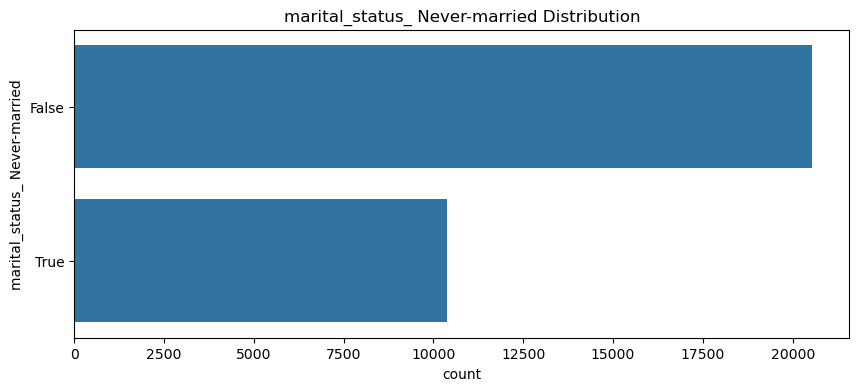

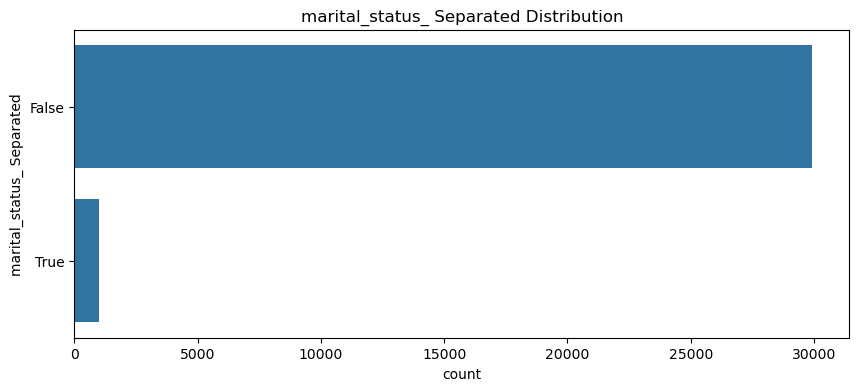

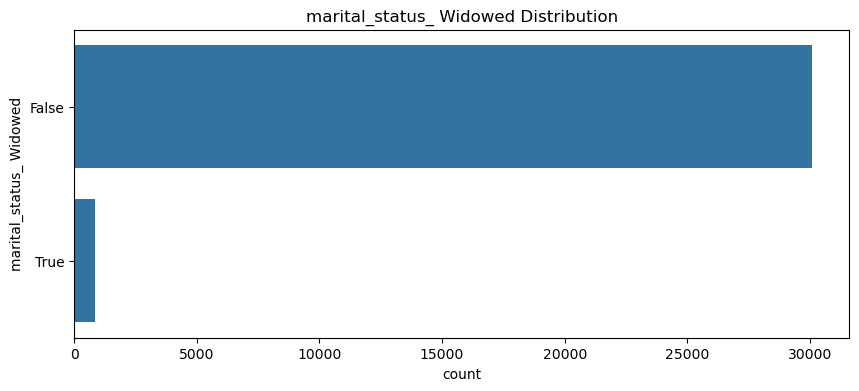

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# List of one-hot encoded marital_status columns
marital_status_cols = [col for col in data_no_outliers.columns if 'marital_status_' in col]

# Plotting the count of each marital_status category
for col in marital_status_cols:
    plt.figure(figsize=(10, 4))
    sns.countplot(y=col, data=data_no_outliers, order = data_no_outliers[col].value_counts().index)
    plt.title(f'{col} Distribution')
    plt.show()


In [ ]:
Conclusion of the Exploratory Data Analysis (EDA):
#In this analysis, we thoroughly explored the dataset to uncover patterns, relationships, and potential insights:

#Data Cleaning:

#Missing values were handled appropriately, and outliers were identified and removed using the Isolation Forest method.

#This step ensured the data quality, which is crucial for reliable model performance.

#Feature Engineering:

#New features like age_squared and hours_education_interaction were created to capture non-linear relationships and interactions between variables.

#This enhancement could improve the predictive power of future models.

#Correlation Analysis:

#A correlation heatmap helped identify strong relationships between numerical features, such as the influence of education_num and hours_per_week on income.

#This information is valuable for feature selection in predictive modeling.

#Categorical Data Analysis:

#We visualized the distribution of categorical variables like marital_status and relationship, which highlighted the diversity of the dataset.

#This step helped understand class imbalances and potential biases in the data.

#Model Preparation:

#The dataset was split into training and testing sets to prepare for machine learning tasks.

#This ensures that model evaluation is performed on unseen data, providing a realistic measure of model performance.

#Key Insights:
#Income Prediction: Features like education_num, hours_per_week, and age have strong predictive potential.

#Data Quality: After cleaning, the dataset is more robust, reducing noise and improving the reliability of subsequent analyses.

#Feature Importance: Understanding which features influence income can guide future data collection and model development.